In [1]:
import numpy as np
import imageio
import math
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from scipy import ndimage

# Hough Transform

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)


def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=5):
    """
    Hough transform for lines
    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between -90 and 90 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

def fast_hough_line(img, angle_step=1, lines_are_white=True, value_threshold=5):
    """hough line using vectorized numpy operations,
    may take more memory, but takes much less time"""
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step)) #can be changed
    #width, height = col.size  #if we use pillow
    width, height = img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_theta = np.cos(thetas)
    sin_theta = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas))
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    #are_edges = cv2.Canny(img,50,150,apertureSize = 3)
    y_idxs, x_idxs = np.nonzero(are_edges)  # (row, col) indexes to edges
    # Vote in the hough accumulator
    xcosthetas = np.dot(x_idxs.reshape((-1,1)), cos_theta.reshape((1,-1)))
    ysinthetas = np.dot(y_idxs.reshape((-1,1)), sin_theta.reshape((1,-1)))
    rhosmat = np.round(xcosthetas + ysinthetas) + diag_len
    rhosmat = rhosmat.astype(np.int16)
    for i in range(num_thetas):
        rhos,counts = np.unique(rhosmat[:,i], return_counts=True)
        accumulator[rhos,i] = counts
    return accumulator, thetas, rhos

def show_hough_line(img, accumulator, thetas, rhos, save_path=None):

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator, cmap='jet',
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    # plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [ ]:
#if __name__ == '__main__':
imgpath = 'images/cat.jpg'
img = imageio.imread(imgpath)
if img.ndim == 3:
    img = rgb2gray(img)
accumulator, thetas, rhos = hough_line(img)
show_hough_line(img, accumulator, thetas, rhos, save_path='images/cat_hough_transform.png')

In [10]:
def hough_transform(img):
    
    width, height = img.shape
    
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, 1))
    diag_len = int(round(np.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)
    
    # Cache some resuable values
    cos_theta = np.cos(thetas)
    sin_theta = np.sin(thetas)
    num_thetas = len(thetas)
    
    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype = np.uint8)
    edges = img > 0
    
    y_idxs, x_idxs = np.nonzero(edges)
    
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        
        for t_idx in range(num_thetas):
            rhos = diag_len + int(round(x * cos_theta[t_idx] + y * sin_theta[t_idx]))
            accumulator[rhos, t_idx] += 1
    return accumulator, thetas, rhos

def show_hough_line(img, accumulator, thetas, rhos, save_path=None):
    
    plt.imshow(accumulator, cmap='gray', extent=[np.deg2rad(thetas[-1]), np.deg2rad(thetas[0]), rhos[-1], rhos[0]])
    plt.title('Hough transform')
    plt.xlabel('Angles (degrees)')
    plt.ylabel('Distance (pixels)')
    plt.axis('image')
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [11]:
imgpath = 'images/cat.jpg'
img = cv2.imread(imgpath)
if img.ndim == 3:
    img = rgb2gray(img)
accumulator, thetas, rhos = hough_transform(img)
show_hough_line(img, accumulator, thetas, rhos, save_path='images/cat_hough_transform.png')

KeyboardInterrupt: 

# Canny edge detection

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [81]:
def sHalf(T, sigma):
    temp = -np.log(T) * 2 * (sigma ** 2)
    return np.round(np.sqrt(temp))

def calculate_filter_size(T, sigma):
    return 2*sHalf(T, sigma) + 1

In [82]:
def MaskGeneration(T, sigma):
    N = calculate_filter_size(T, sigma)
    shalf = sHalf(T, sigma)
    y, x = np.meshgrid(range(-int(shalf), int(shalf) + 1), range(-int(shalf), int(shalf) + 1))
    return x, y

In [143]:
def Gaussian(x,y, sigma):
    temp = ((x ** 2) + (y ** 2)) / (2 * (sigma ** 2))
    return (np.exp(-temp))

def calculate_gradient_X(x,y, sigma):
    temp = (x ** 2 + y ** 2) / (2 * sigma ** 2)
    return -((x * np.exp(-temp)) / sigma ** 2)

def calculate_gradient_Y(x,y, sigma):
    temp = (x ** 2 + y ** 2) / (2 * sigma ** 2)
    return -((y * np.exp(-temp)) / sigma ** 2)

In [145]:
def pad(img, kernel):
    r, c = img.shape
    kr, kc = kernel.shape
    padded = np.zeros((r + kr,c + kc), dtype=img.dtype)
    insert = np.uint((kr)/2)
    padded[insert: insert + r, insert: insert + c] = img
    return padded
            
def smooth(img, kernel=None):
    if kernel is None:
        mask = np.array([[1,1,1],[1,1,1],[1,1,1]])
    else:
        mask = kernel
    i, j = mask.shape
    output = np.zeros((img.shape[0], img.shape[1]))           
    image_padded = pad(img, mask)
    for x in range(img.shape[0]):    
        for y in range(img.shape[1]):
            output[x, y] = (mask * image_padded[x:x+i, y:y+j]).sum() / mask.sum()  
    return output

In [146]:
def Create_Gx(fx, fy):
    gx = calculate_gradient_X(fx, fy, sigma)
    gx = (gx * 255)
    return np.around(gx)

def Create_Gy(fx, fy):    
    gy = calculate_gradient_Y(fx, fy, sigma)
    gy = (gy * 255)
    return np.around(gy)

In [147]:
def ApplyMask(image, kernel):
    i, j = kernel.shape
    kernel = np.flipud(np.fliplr(kernel))    
    output = np.zeros_like(image)           
    image_padded = pad(image, kernel)
    for x in range(image.shape[0]):    
        for y in range(image.shape[1]):
            output[x, y] = (kernel * image_padded[x:x+i, y:y+j]).sum()        
    return output

In [148]:
def Gradient_Magnitude(fx, fy):
    mag = np.zeros((fx.shape[0], fx.shape[1]))
    mag = np.sqrt((fx ** 2) + (fy ** 2))
    mag = mag * 100 / mag.max()
    return np.around(mag)

def Gradient_Direction(fx, fy):
    g_dir = np.zeros((fx.shape[0], fx.shape[1]))
    g_dir = np.rad2deg(np.arctan2(fy, fx)) + 180
    return g_dir

In [149]:
def Digitize_angle(Angle):
    quantized = np.zeros((Angle.shape[0], Angle.shape[1]))
    for i in range(Angle.shape[0]):
        for j in range(Angle.shape[1]):
            if 0 <= Angle[i, j] <= 22.5 or 157.5 <= Angle[i, j] <= 202.5 or 337.5 < Angle[i, j] < 360:
                quantized[i, j] = 0
            elif 22.5 <= Angle[i, j] <= 67.5 or 202.5 <= Angle[i, j] <= 247.5:
                quantized[i, j] = 1
            elif 67.5 <= Angle[i, j] <= 122.5 or 247.5 <= Angle[i, j] <= 292.5:
                quantized[i, j] = 2
            elif 112.5 <= Angle[i, j] <= 157.5 or 292.5 <= Angle[i, j] <= 337.5:
                quantized[i, j] = 3
    return quantized
    
def Non_Max_Supp(qn, magni, D):
    M = np.zeros(qn.shape)
    a, b = np.shape(qn)
    for i in range(a-1):
        for j in range(b-1):
            if qn[i,j] == 0:
                if  magni[i,j-1]< magni[i,j] or magni[i,j] > magni[i,j+1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
            if qn[i,j]==1:
                if  magni[i-1,j+1]<= magni[i,j] or magni[i,j] >= magni[i+1,j-1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0       
            if qn[i,j] == 2:
                if  magni[i-1,j]<= magni[i,j] or magni[i,j] >= magni[i+1,j]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
            if qn[i,j] == 3:
                if  magni[i-1,j-1]<= magni[i,j] or magni[i,j] >= magni[i+1,j+1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
    return M

def color(quant, mag):
    color = np.zeros((mag.shape[0], mag.shape[1], 3), np.uint8)
    a, b = np.shape(mag)
    for i in range(a-1):
        for j in range(b-1):
            if quant[i,j] == 0:
                if mag[i,j] != 0:
                    color[i,j,0] = 255
                else:
                    color[i,j,0] = 0
            if quant[i,j] == 1:
                if mag[i,j] != 0:
                    color[i,j,1] = 255
                else:
                    color[i,j,1] = 0
            if quant[i,j] == 2:
                if mag[i,j] != 0:
                    color[i,j,2] = 255
                else:
                    color[i,j,2] = 0
            if quant[i,j] == 3:
                if mag[i,j] != 0:
                    color[i,j,0] = 255
                    color[i,j,1] = 255
                    
                else:
                    color[i,j,0] = 0
                    color[i,j,1] = 0
    return color

In [150]:
def _double_thresholding(g_suppressed, low_threshold, high_threshold):
    g_thresholded = np.zeros(g_suppressed.shape)
    for i in range(0, g_suppressed.shape[0]):  # loop over pixels
        for j in range(0, g_suppressed.shape[1]):
            if g_suppressed[i,j] < low_threshold:  # lower than low threshold
                g_thresholded[i,j] = 0
            elif g_suppressed[i,j] >= low_threshold and g_suppressed[i,j] < high_threshold: 	# between thresholds
                g_thresholded[i,j] = 128
            else:  # higher than high threshold
                g_thresholded[i,j] = 255
    return g_thresholded

def _hysteresis(g_thresholded):
    g_strong = np.zeros(g_thresholded.shape)
    for i in range(0, g_thresholded.shape[0]):  # loop over pixels
        for j in range(0, g_thresholded.shape[1]):
            val = g_thresholded[i,j]
            if val == 128:  # check if weak edge connected to strong
                if g_thresholded[i-1,j] == 255 or g_thresholded[i+1,j] == 255 or g_thresholded[i-1,j-1] == 255 or g_thresholded[i+1,j-1] == 255 or g_thresholded[i-1,j+1] == 255 or g_thresholded[i+1,j+1] == 255 or g_thresholded[i,j-1] == 255 or g_thresholded[i,j+1] == 255:
                    g_strong[i,j] = 255  # replace weak edge as strong
            elif val == 255:
                g_strong[i,j] = 255  # strong edge remains as strong edge
    return g_strong

In [ ]:
# image1 (fingerprint)

# Step 1: Specify sigma and T value Also calculate Gradient masks

In [152]:
sigma = 0.5
T = 0.3
x, y = MaskGeneration(T, sigma)
gauss = Gaussian(x, y, sigma)

In [91]:
gx = -Create_Gx(x, y)
gy = -Create_Gy(x, y)

# Step 2: Reading and converting image into grayscale

Here we convert the image into grayscale image for easy processing and finding edges

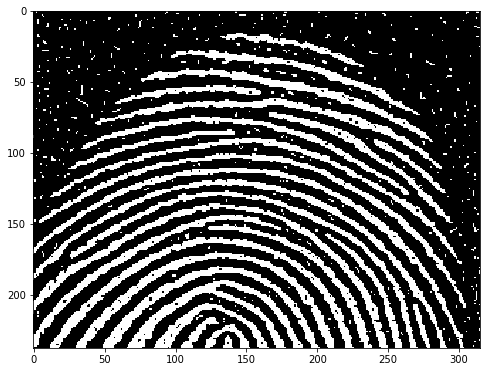

In [92]:
image = cv2.imread('./images2/noisy_fingerprint.tif')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (8,8))
plt.imshow(gray, cmap='gray')
plt.show()

Smoothing (Here we smooth the image to reduce the intensity in the pixels)

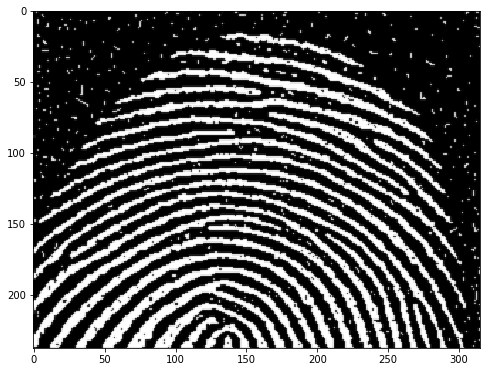

In [93]:
smooth_img = smooth(gray, gauss)
plt.figure(figsize = (8,8))
plt.imshow(smooth_img, cmap='gray')

# Step 3: Applying the Gradient masks

In this step we apply the gradient x and y masks on the image.

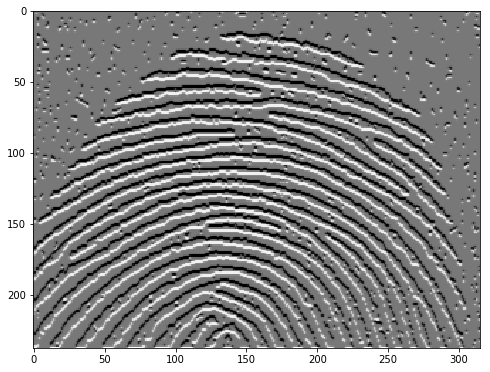

In [94]:
fx = ApplyMask(smooth_img, gx)
plt.figure(figsize = (8,8))
plt.imshow(fx, cmap='gray')

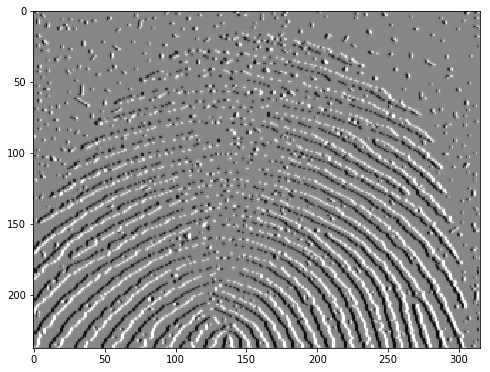

In [95]:
fy = ApplyMask(smooth_img, gy)
plt.figure(figsize = (8,8))
plt.imshow(fy, cmap='gray')

# Step 4: Gradient magnitude

max 100
min 0


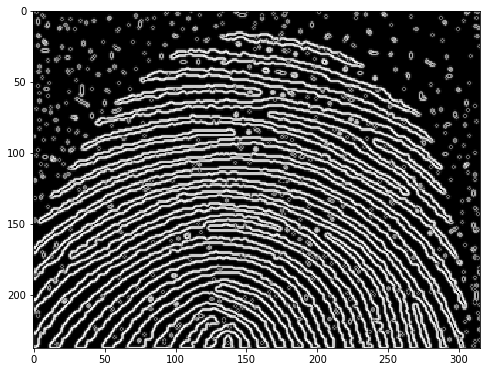

In [96]:
mag = Gradient_Magnitude(fx, fy)
mag = mag.astype(int)
plt.figure(figsize = (8,8))
plt.imshow(mag, cmap='gray')
print('max', mag.max())
print('min', mag.min())

# STEP 5: Gradient Direction# STEP 5 Gradient Direction

In this step we find direction of gradient at each pixel of the image.

max 360.0
min 0.0


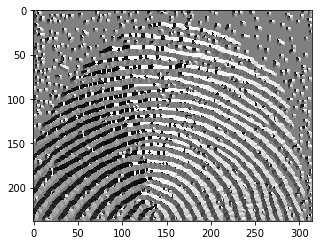

In [97]:
Angle = Gradient_Direction(fx, fy)
plt.figure(figsize = (5,5))
plt.imshow(Angle, cmap='gray')
print('max', Angle.max())
print('min', Angle.min())

# Step 6: Quantization of angles and Non-Max Suppression

In this step we quantize our angles into 4 groups 0, 1, 2, 3. Then we apply non-maximum suppression on it to make the edges thin

max 100.0
min 0.0


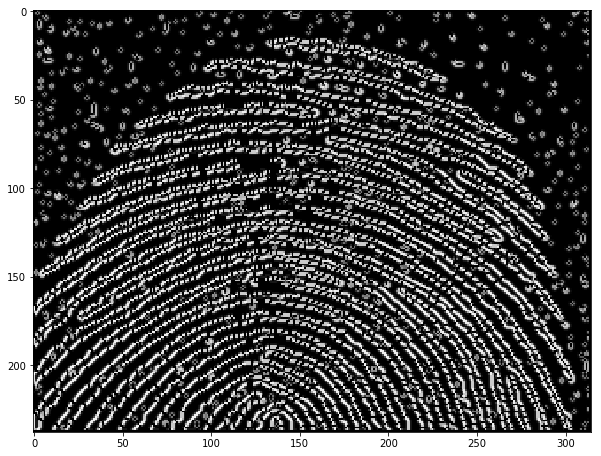

In [98]:
quantized = Digitize_angle(Angle)
nms = Non_Max_Supp(quantized, Angle, mag)
plt.figure(figsize = (10,10))
plt.imshow(nms, cmap='gray')
print('max', nms.max())
print('min', nms.min())

True

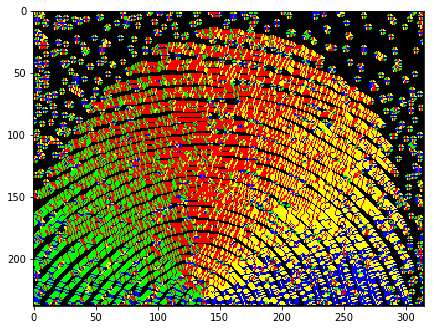

In [99]:
# Colorized Image for visualiztion of angles
colorized = color(quantized, mag)
plt.figure(figsize = (7,7))
plt.imshow(colorized)
cv2.imwrite('color.jpg',colorized)

# Step 7: Double Threshold and Hysteresis

In this step we apply double threshold Tl and Th to our non-maximum suppressed images. After that we apply Hysteresis algorithm to get resultant edges of the image

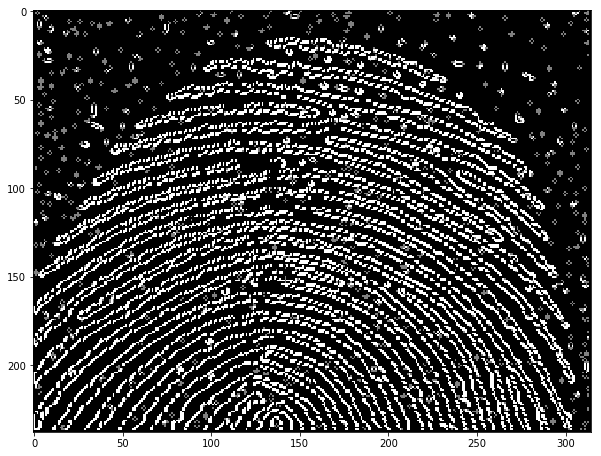

In [100]:
threshold = _double_thresholding(nms, 30, 60)
cv2.imwrite('double_thresholded.jpg', threshold )
plt.figure(figsize = (10,10))
plt.imshow(threshold, cmap='gray')

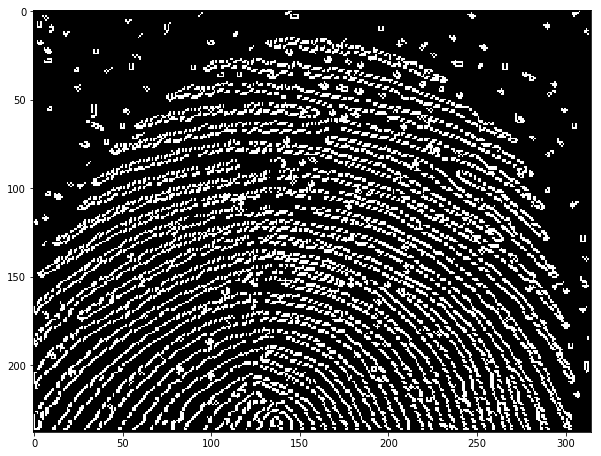

In [107]:
hys = _hysteresis(threshold)
cv2.imwrite('./images2/Finger_canny_result.jpg', hys)
plt.figure(figsize = (10,10))
plt.imshow(hys, cmap='gray')

# With OpenCV

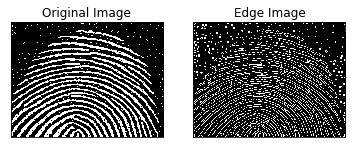

True

In [128]:
img = cv2.imread('./images2/noisy_fingerprint.tif')
edges = cv2.Canny(img, 100, 200)

plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(edges, cmap = 'gray')
plt.title('Edge Image')
plt.xticks([])
plt.yticks([])
plt.show()

cv2.imwrite('./images2/Finger_canny_result_withcv.jpg', edges)

In [ ]:
# image2 (cat)

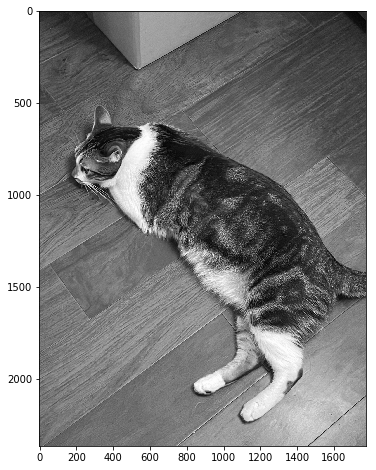

In [122]:
image = cv2.imread('./images2/cat.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (8,8))
plt.imshow(gray, cmap='gray')
plt.show()

In [112]:
image_path = "./images2"
save_path = "./images2/results"

In [120]:
for filename in os.listdir(image_path):
    print(filename.split('.')[0])

cat
noisy_fingerprint
results


error: OpenCV(4.3.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


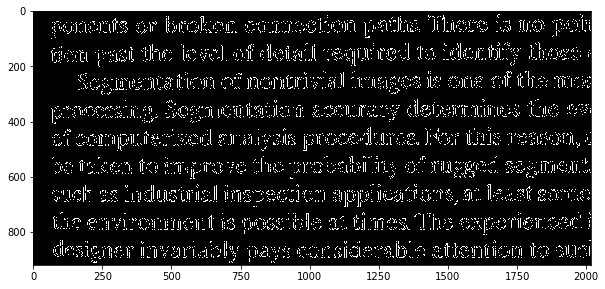

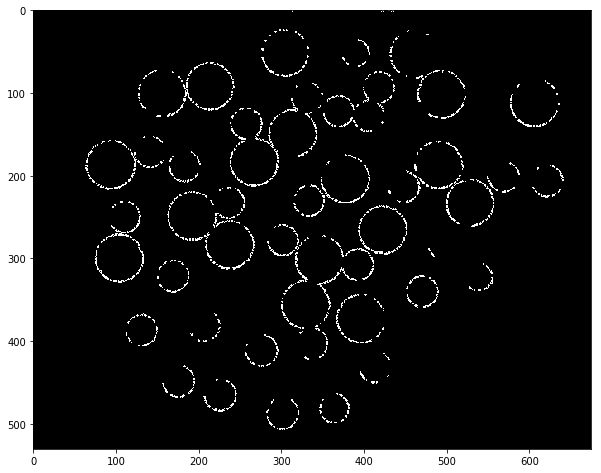

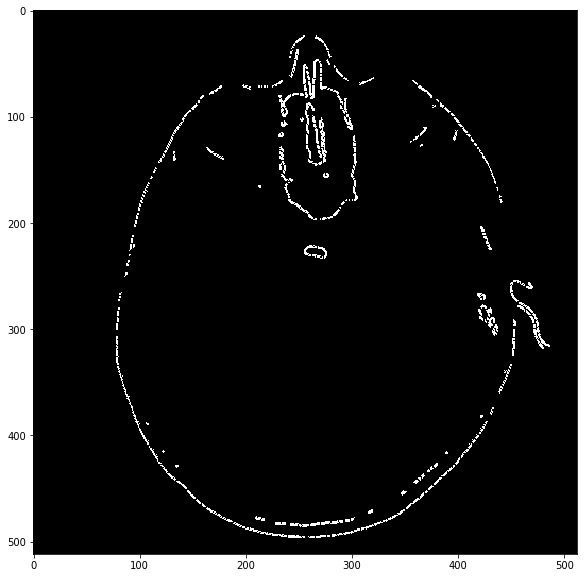

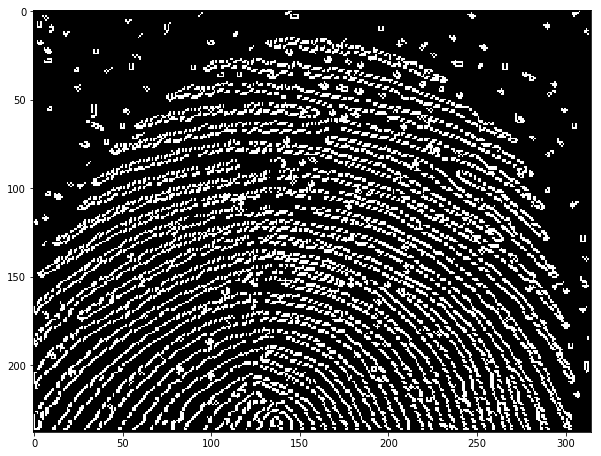

In [137]:
for filename in os.listdir(image_path):
    
    image = cv2.imread(image_path + '/' + filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    smooth_img = smooth(gray, gauss)
    fx = ApplyMask(smooth_img, gx)
    fy = ApplyMask(smooth_img, gy)
    
    mag = Gradient_Magnitude(fx, fy)
    mag = mag.astype(int)
    
    Angle = Gradient_Direction(fx, fy)
    
    quantized = Digitize_angle(Angle)
    nms = Non_Max_Supp(quantized, Angle, mag)
    
    threshold = _double_thresholding(nms, 30, 60)
    
    hys = _hysteresis(threshold)
    cv2.imwrite(save_path + '/' + filename.split('.')[0] + "_canny_result.png", hys)
    plt.figure(figsize = (10,10))
    plt.imshow(hys, cmap='gray')

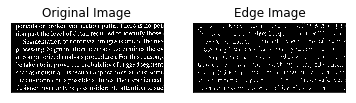

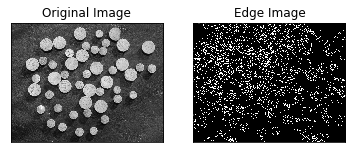

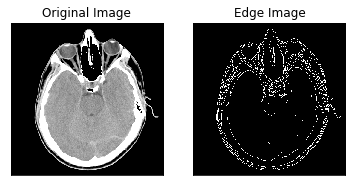

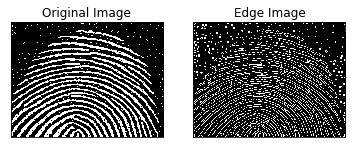

TypeError: Image data cannot be converted to float

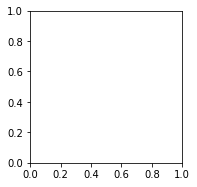

In [138]:
for filename in os.listdir(image_path):
    
    image = cv2.imread(image_path + '/' + filename)
    edges = cv2.Canny(image, 100, 200)

    plt.subplot(121)
    plt.imshow(image, cmap = 'gray')
    plt.title('Original Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(122)
    plt.imshow(edges, cmap = 'gray')
    plt.title('Edge Image')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    cv2.imwrite(save_path + '/' + filename.split('.')[0] + "_canny_result_withcv.png", edges)

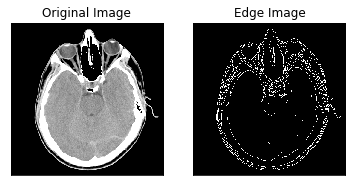

True

In [129]:
img = cv2.imread('./images2/Fig1026(a)(headCT-Vandy).tif')
edges = cv2.Canny(img, 100, 200)

plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(edges, cmap = 'gray')
plt.title('Edge Image')
plt.xticks([])
plt.yticks([])
plt.show()

cv2.imwrite('./images2/headCT_canny_result_withcv.jpg', edges)

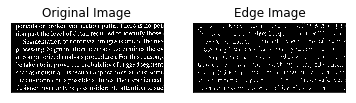

True

In [131]:
img = cv2.imread('./images2/Fig0929(a)(text_image).tif')
edges = cv2.Canny(img, 100, 200)

plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(edges, cmap = 'gray')
plt.title('Edge Image')
plt.xticks([])
plt.yticks([])
plt.show()

cv2.imwrite('./images2/text_canny_result_withcv.jpg', edges)

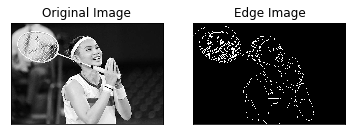

True

In [140]:
img = cv2.imread('./images2/Tai_tzu_ying.jpg', cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(img, 100, 200)

plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(edges, cmap = 'gray')
plt.title('Edge Image')
plt.xticks([])
plt.yticks([])
plt.show()

cv2.imwrite('./images2/tai_canny_result_withcv.jpg', edges)

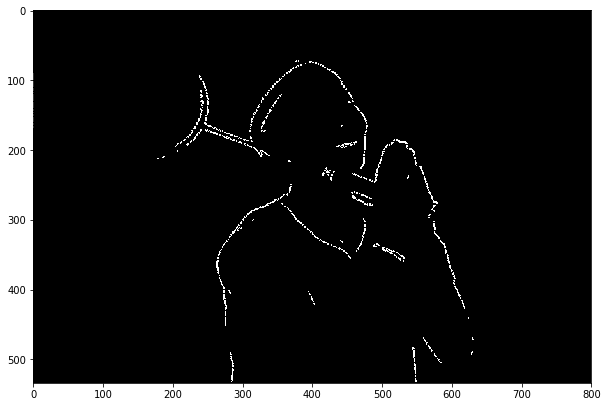

In [153]:
image = cv2.imread('./images2/Tai_tzu_ying.jpg', cv2.IMREAD_GRAYSCALE)
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

smooth_img = smooth(image, gauss)
fx = ApplyMask(smooth_img, gx)
fy = ApplyMask(smooth_img, gy)

mag = Gradient_Magnitude(fx, fy)
mag = mag.astype(int)

Angle = Gradient_Direction(fx, fy)

quantized = Digitize_angle(Angle)
nms = Non_Max_Supp(quantized, Angle, mag)

threshold = _double_thresholding(nms, 30, 60)

hys = _hysteresis(threshold)
cv2.imwrite(save_path + '/' + filename.split('.')[0] + "_canny_result.png", hys)
plt.figure(figsize = (10,10))
plt.imshow(hys, cmap='gray')

In [2]:
def dilation(img1):

    p, q = img1.shape

    # Define new image to store the pixels of dilated image
    imgDilate = np.zeros((p,q), dtype=np.uint8)

    # Define the structuring element 
    SED = np.array([[0,1,0], [1,1,1], [0,1,0]])
    constant1 = 1

    # Dilation
    for i in range(constant1, p-constant1):
        for j in range(constant1, q-constant1):
            temp = img1[i-constant1:i+constant1+1, j-constant1:j+constant1+1]
            product = temp*SED
            imgDilate[i,j] = np.max(product)

    plt.imshow(imgDilate, cmap = "gray")
    cv2.imwrite("./images/dilated_finger.png", imgDilate)
    
    return imgDilate

In [3]:
def thresholdimg(img, n):
    img_shape = img.shape
    height = img_shape[0]
    width = img_shape[1]
    for row in range(width):
        for column in range(height):
            if img[column, row] > n:
                img[column, row] = 0
            else:
                img[column, row] = 255
    return img

-1

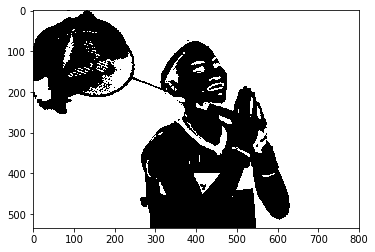

In [5]:
## Test my idea for improving the performance of edge detection

# read image
img = cv2.imread("./images2/Tai_tzu_ying.jpg")

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold
threshold = thresholdimg(gray, 127)

# morphology edgeout = dilated_mask - mask
# morphology dilate
dilate = dilation(threshold)

# get absolute difference between dilate and thresh
diff = dilate - threshold

# invert
edges = 255 - diff

# write result to disk
cv2.imwrite("./images2/results/Tai_threshold.jpg", threshold)
cv2.imwrite("./images2/results/Tai_dilate.jpg", dilate)
cv2.imwrite("./images2/results/Tai_diff.jpg", diff)
cv2.imwrite("./images2/results/Tai_edges.jpg", edges)

# display it
cv2.imshow("thresh", threshold)
cv2.imshow("dilate", dilate)
cv2.imshow("diff", diff)
cv2.imshow("edges", edges)
cv2.waitKey(0)